In [63]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler
import cupy as cp
from PyALE import ale
from sklearn.ensemble import RandomForestClassifier as sk_rfc
import numpy as np
from sklearn.metrics import roc_auc_score


# Interpretable Machine Learning

In this section we will pick the model with the best performance in the classification task because the main task in our dataset is predicting Credit Default or No Default. nterpretability in machine learning models for predicting credit default is crucial because it allows stakeholders, such as banks or financial institutions, to understand how the model makes its decisions. This transparency helps ensure fairness, builds trust with customers, and enables regulatory compliance. Moreover, interpretability allows for better identification of underlying factors contributing to credit risk, facilitating more informed decision-making.

We will use the ALE plot to visualize the effect of each of the features on predictions. We are using this instead of PDPs because these last are sensitive to correlated data, which is very common in real life datasets.

First, we will load the model and the data.

In [57]:
data = pd.read_parquet('../data/processed/selected_features_df.parquet')
model = joblib.load("../models/randomForestClassifier.pkl")

X = data.drop(columns=['TARGET'])
y = data['TARGET']

feature_names = X.columns.tolist()

Standarizing the data

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

We are going to use SelectFromModel to get the most important features for our model.

In [59]:
rf_classifier = sk_rfc()
selector = SelectFromModel(estimator=rf_classifier).fit(X_scaled, y)
X_selected = selector.transform(X_scaled)

Save the names of the selected features

In [60]:
selected_columns = X_scaled.columns[selector.get_support()]

We need to resample to treat the class imbalance. We create the training and test sets.

In [61]:
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X_selected, y)
X_resampled = pd.DataFrame(X_resampled,columns=selected_columns)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

We convert the data to type np.float32

In [62]:
X_train_32 = X_train.astype(np.float32)

Let's test the ROC_AUC_SCORE to see how good the model is.

In [65]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

0.9554947275388302


The model is excellent. For the ALE plots we are going to use a sample of 10000 rows. If we use all the data, the time to get all the plot is really high. We believe that for the scope of the project is fine to use a sample.

In [43]:
X_train_32_sample = X_train_32.sample(n=10000).reset_index(drop=True)
y_train_sample = y_train.iloc[X_train_32_sample.index].reset_index(drop=True)

Fit the model with the sample

In [44]:
model = model.fit(X_train_32_sample, y_train_sample)

Make the ALE plots

PyALE._ALE_generic:INFO: Continuous feature detected.
/home/aitor/anaconda3/envs/rapids-24.10/lib/python3.10/site-packages/PyALE/_src/ALE_1D.py:45: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_1 = model.predict(X1).ravel()
/home/aitor/anaconda3/envs/rapids-24.10/lib/python3.10/site-packages/PyALE/_src/ALE_1D.py:46: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_2 = model.predict(X2).ravel()
PyALE._ALE_generic:INFO: Continuous feature detected.
/home/aitor/anaconda3/envs/rapids-24.10/lib/python3.10/site-packages/PyALE/_src/ALE_1D.py:45: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_1 = model.predict(X1).ravel()
/home/aitor/a

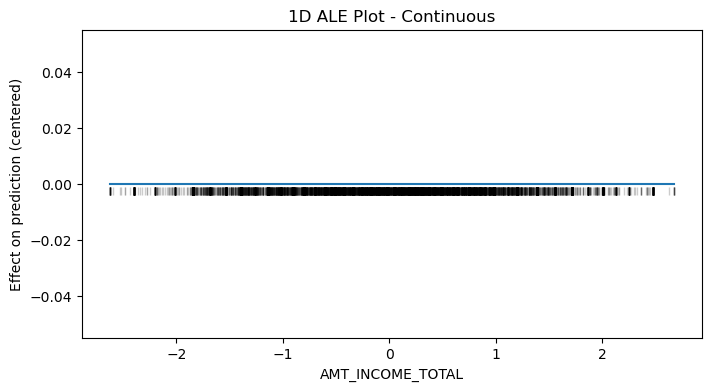

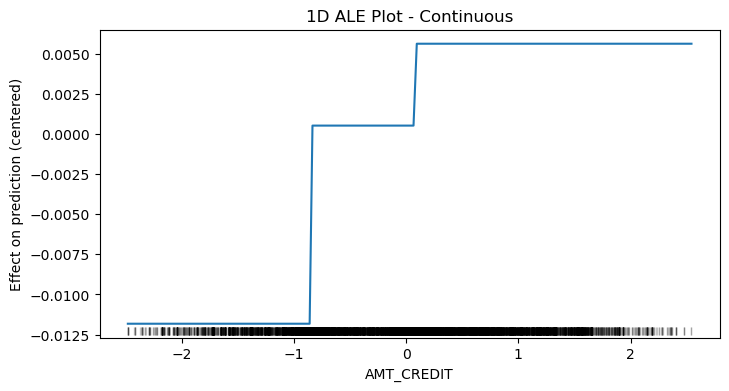

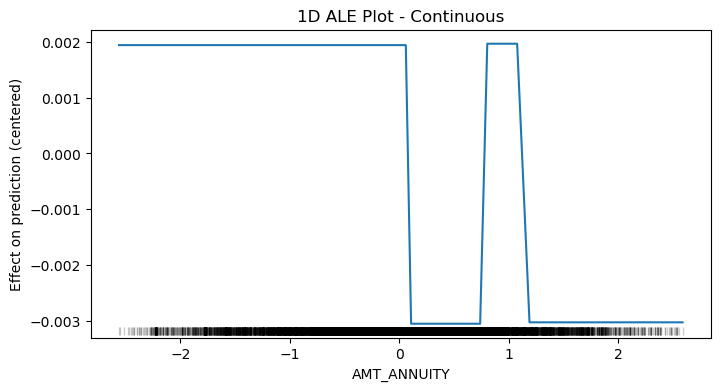

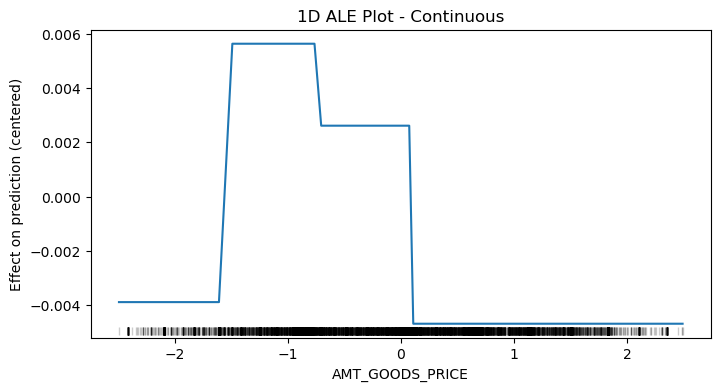

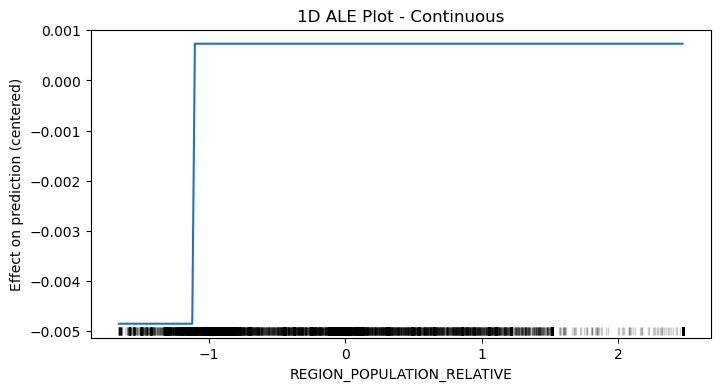

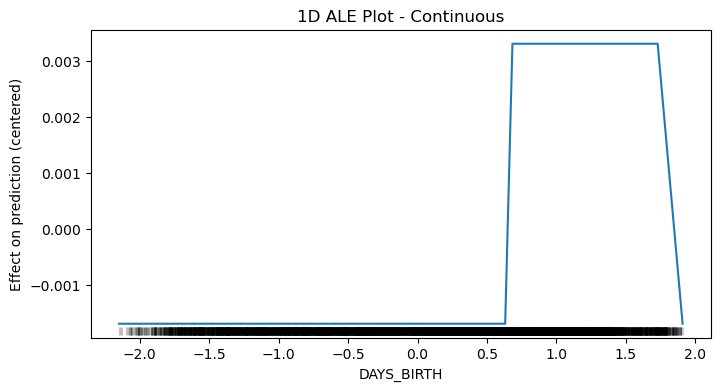

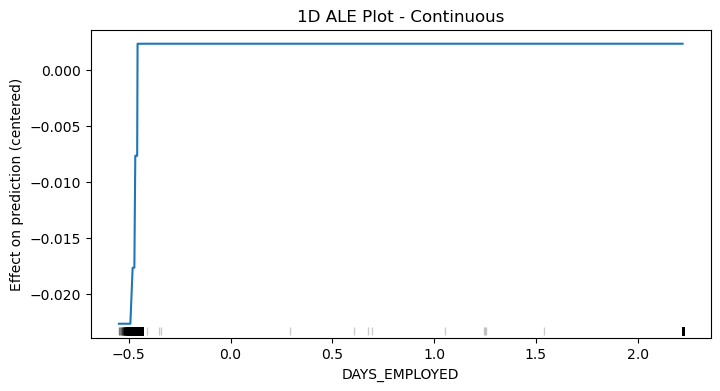

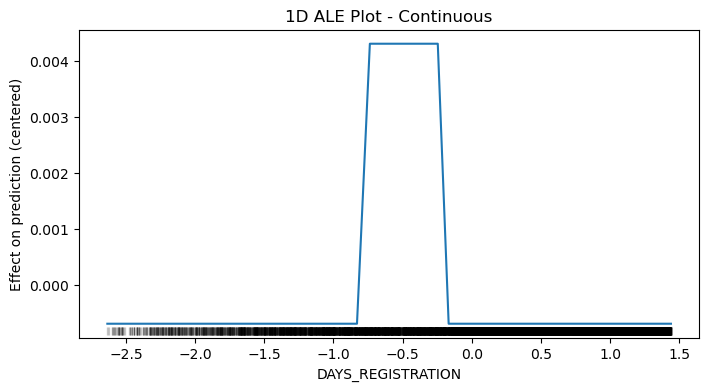

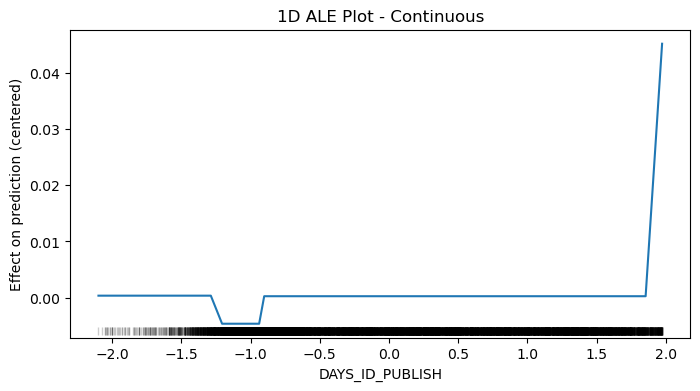

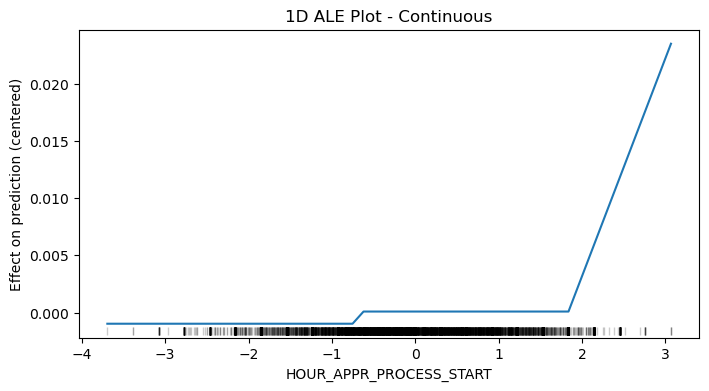

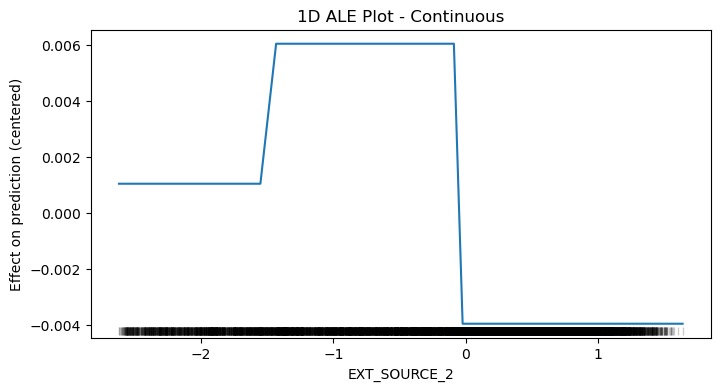

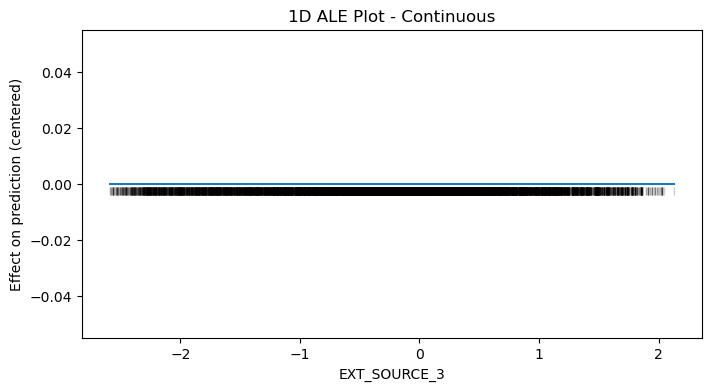

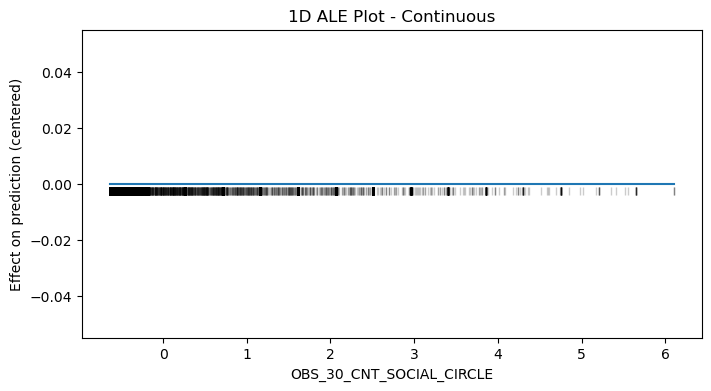

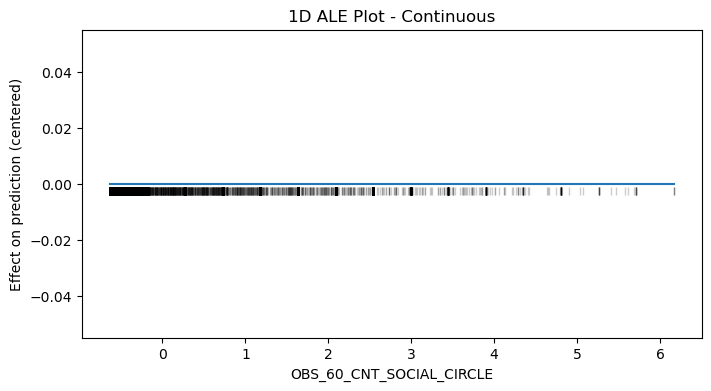

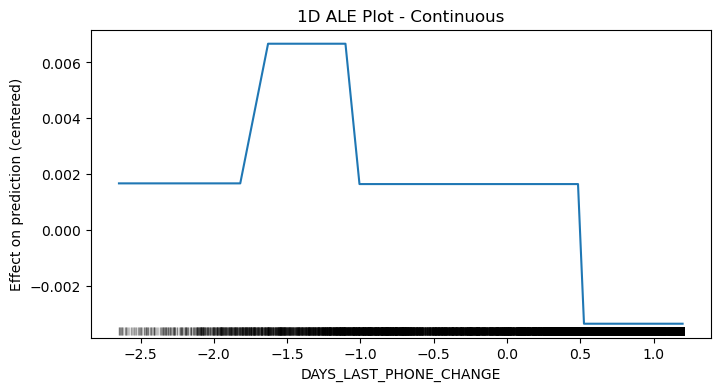

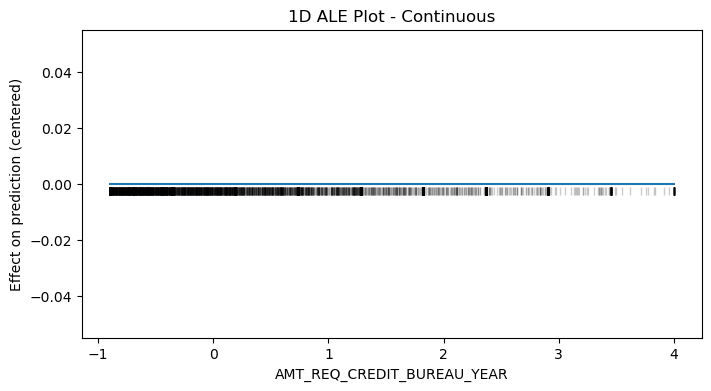

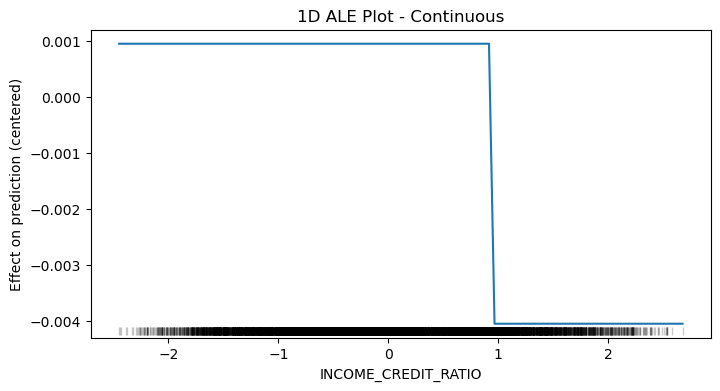

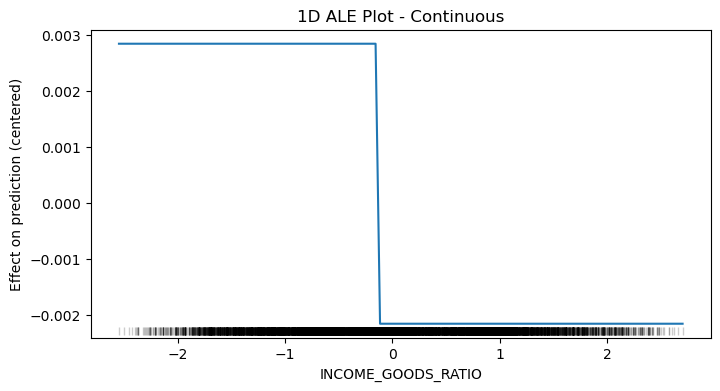

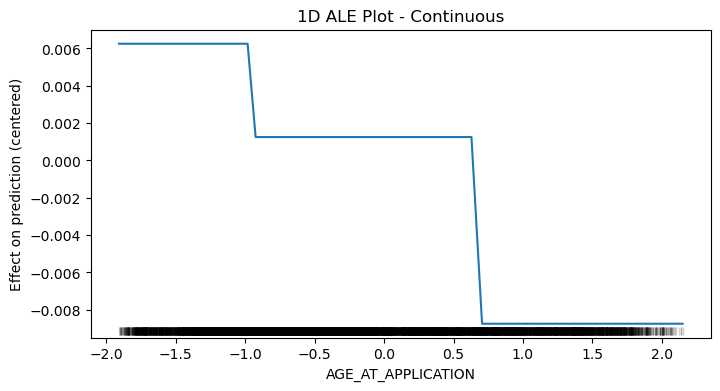

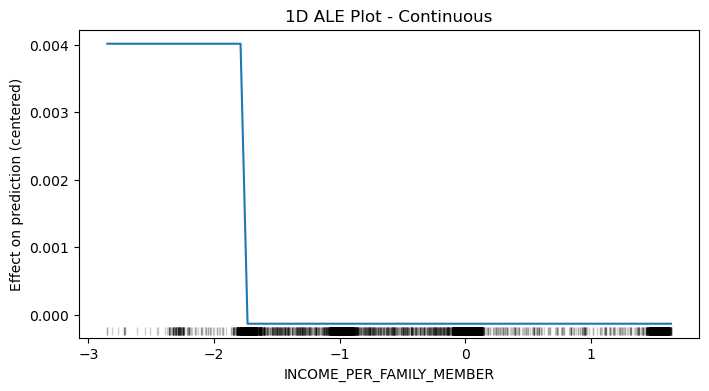

In [48]:
for feature_name in X_train_32_sample.columns:
    ale_plot = ale(X_train_32_sample, model, feature=[feature_name], grid_size=50,include_CI=False)

To interpret this ALE plots we have to take into consideration, that if the value is above 0 it increases the probability of predicting a Default. If the probability is below 0, it increases the probability of No Default. Here there are some interesting findings:

* AMT_INCOME_TOTAL doesn't affect the prediction as its value is always 0. Which is an interesting finding considering that, at first glance, we might think that the lower the income, the higher the probability of default.
* In AMT_CREDIT we can see that until a concrete credit amount it decreases the probability of Default, but after a certain value it increases considereably the probability of Default.
* Low values in INCOME_PER_FAMILY_MEMBER increases the probability of Default.
* Looking at AGE_AT_APPLICATION, the younger you are, the higher the probability of default. After a certain age, the probability of default starts to decrease.
* According to INCOME_GOODS_RATIO, low values increase your probability of default, while high values decrease it.
* Low values in INCOME_CREDIT_RATIO increase the probability of default, while high values decrease it.
* Individuals with a low value in DAYS_LAST_PHONE_CHANGE have a higher probability of default.
* Very high values in HOUR_APPR_PROCESS_START and DAYS_ID_PUBLISH significantly increase the probability of default.
* High, uncommon values in DAYS_EMPLOYED increase the probability of default.
* Low values in AMT_GOODS_PRICE increase the probability of default.